In [28]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image
from wordcloud import WordCloud
from google.cloud import language_v1
import io
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "lustrous-center-305403-9cd548f48b67.json"

# 1. Data Cleaning

In [2]:
# read data
data_test = pd.read_csv('religious_text_test.csv')
data_train = pd.read_csv('religious_text_train.csv')

In [19]:
# fill missing values
data_train[:] = data_train.fillna(0)
data_test[:] = data_test.fillna(0)

# rename the unnamed column to Chapters, '# foolishness' to just foolishness
data_train.rename(columns = {'Unnamed: 0' : 'Chapters'}, inplace = True)
data_test.rename(columns = {'# foolishness' : 'foolishness'}, inplace = True)

# make sure everything is an integer
data_test = data_test.applymap(int).astype(int)
data_train.iloc[:, 1:] = data_train.iloc[:, 1:].applymap(int).astype(int)

In [4]:
# Data validation stuff, more cleaning

all(data_train.iloc[:,1:].dtypes == 'int64') # True (All entries are integers)
all(data_test.dtypes == 'int64') # True (All entries are integers)

all(list(map(lambda a: ' ' not in a, data_train.iloc[:,1:].columns))) # Each column is one word
all(list(map(lambda a: ' ' not in a, data_test.columns))) # Each column is one word

True

In [6]:
# Data to work with 

# Extraaaaaa way of getting the books lmao, dont do this
books = [i[0] for i in list(map(lambda a: a.split('_'), data_train['Chapters'].unique())) if i[1] == 'Ch1']

# dataframes segregated by chapters
book_list = [data_train[[j in i for i in data_train['Chapters']]] for j in books]

# top 20 words for each book in a list containing 8 series
top_20_books = [j.sort_values(ascending = False) for j in [i.iloc[:,1:].sum() for i in book_list]]

# total words in each book
total_words_book = dict(zip(books, [i.sum() for i in top_20_books]))

# total words in each chapter of each book (dictionary)
total_words_chapter = dict(zip(books,[pd.Series(data=i.iloc[:,1:].sum(axis=1).tolist(), index=i.iloc[:,0]) for i in book_list]))

# Top 20 words for all books
all_20 = data_train.iloc[:,1:].sum().sort_values(ascending = False)

# total words in the dataframe 
total_words = all_20.sum()

# proportion of words in the top 20 over total words in each book 
prop_20_book = dict(zip(books,[top_20_books[i][:20].sum() / [j.sum() for j in top_20_books][i] for i in range(8)]))

In [7]:
# Word cloud visualizations (ready for graphing)

mask = np.array(Image.open("book.png"))

# for all books in total
desc = all_20.index.tolist(); counts = all_20.tolist()
wordcloud_20 = WordCloud(mask = mask, max_words = len(all_20)).generate_from_frequencies(dict(zip(desc,counts))) # stored here

# for each book (in a list)
word_cloud_each = [] # all in this list
for i in top_20_books:
    desc = i[:20].index.tolist(); counts = i[:20].tolist()
    word_cloud_each.append(WordCloud(max_words = 20).generate_from_frequencies(dict(zip(desc,counts))))

In [8]:
def analyze_entities(text_content):
    client = language_v1.LanguageServiceClient()

    # text_content = 'California is a state.'

    # Available types: PLAIN_TEXT, HTML
    type_ = language_v1.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": text_content, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_entities(request = {'document': document, 'encoding_type': encoding_type})

    # Loop through entitites returned from the API
    for entity in response.entities:
        print(u"Representative name for the entity: {}".format(entity.name))

        # Get entity type, e.g. PERSON, LOCATION, ADDRESS, NUMBER, et al
        print(u"Entity type: {}".format(language_v1.Entity.Type(entity.type_).name))

        # Get the salience score associated with the entity in the [0, 1.0] range
        print(u"Salience score: {}".format(entity.salience))

        # Loop over the metadata associated with entity. For many known entities,
        # the metadata is a Wikipedia URL (wikipedia_url) and Knowledge Graph MID (mid).
        # Some entity types may have additional metadata, e.g. ADDRESS entities
        # may have metadata for the address street_name, postal_code, et al.
        for metadata_name, metadata_value in entity.metadata.items():
            print(u"{}: {}".format(metadata_name, metadata_value))

        # Loop over the mentions of this entity in the input document.
        # The API currently supports proper noun mentions.
        for mention in entity.mentions:
            print(u"Mention text: {}".format(mention.text.content))

            # Get the mention type, e.g. PROPER for proper noun
            print(
                u"Mention type: {}".format(language_v1.EntityMention.Type(mention.type_).name)
            )

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(u"Language of the text: {}".format(response.language))

In [10]:
# This code basically takes all scores calculated from the sentiment analysis text file,
# in order to help with sentiment score calculations 

sentiments = open('sentiment_analysis.txt', 'r')
scores = [float(line.split(' ')[3].strip()) for line in sentiments.readlines() if 'score' in line and 'Document' in line][1:]
sentiments.seek(0)
magnitude = [float(line.split(' ')[3].strip()) for line in sentiments.readlines() if 'magnitude' in line and 'Document' in line][1:]
sentiments.seek(0)
keys = [line.strip() for line in sentiments.readlines() if ' ' not in line and line.rstrip()]
scores_dict = dict(zip(keys,scores))
magnitude_dict = dict(zip(keys,magnitude))

# function to calculate sentiment scores
book_scores = list(map((lambda j: sum([scores_dict[k] * j[i] for i,k in enumerate(j.index.tolist())]) / sum(j.tolist())), top_20_books))
magnitude_scores = list(map((lambda j: sum([magnitude_dict[k] * j[i] for i,k in enumerate(j.index.tolist())]) / sum(j.tolist())), top_20_books))
top_20_scores = list(map((lambda j: sum([scores_dict[k] * j[:20][i] for i,k in enumerate(j[:20].index.tolist())]) / sum(j[:20].tolist())), top_20_books))
top_20_magnitude = list(map((lambda j: sum([magnitude_dict[k] * j[:20][i] for i,k in enumerate(j[:20].index.tolist())]) / sum(j[:20].tolist())), top_20_books))

# formatting the scores for graphing/visualization
scores_20 = dict(zip(books,list(top_20_scores)))
magnitude_20 = dict(zip(books,list(top_20_magnitude)))
book_scores_dict = dict(zip(books,list(book_scores)))
book_magnitude_dict = dict(zip(books,list(magnitude_scores)))

In [11]:
#Creating a deep copy of total_words
total_words_chapter_copy = {key: value[:] for key, value in total_words_chapter.items()}

#Deleting Chapter 27 From Buddhism
total_words_chapter_copy["Buddhism"].pop('Buddhism_Ch37')

1194

# 2. Visualizations

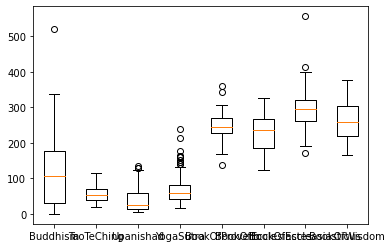

In [12]:
#BoxPlot
chapters_dict = {}
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    chapters_dict[book] = chapters_count

fig, ax = plt.subplots()
ax.boxplot(chapters_dict.values())
ax.set_xticklabels(chapters_dict.keys())
plt.show()

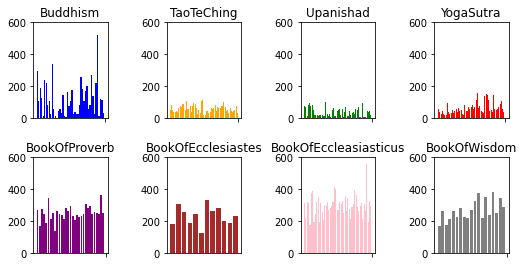

In [13]:
figure, axes = plt.subplots(nrows=2, ncols=4)
plt.title("Words Per Chapter")
colors = ['','blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
index = 1
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    
    plt.subplot(2, 4, index) # row 1, col 2 index 1
    plt.bar(chapters, chapters_count, color = colors[index])
    plt.ylim(0, 600)
    plt.title(book)
    plt.xticks(" ")
    index += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.2, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

plt.show()

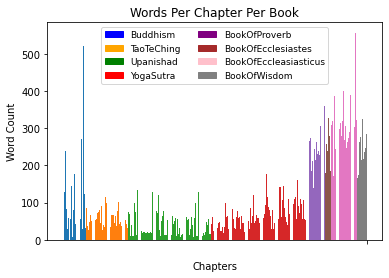

In [14]:
# Combined Barcharts
for book in total_words_chapter_copy.keys():
    chapters = [key for key in total_words_chapter_copy[book].keys()]
    chapters_count = [total_words_chapter_copy[book][key] for key in total_words_chapter_copy[book].keys()]
    plt.bar(chapters, chapters_count)

plt.xlabel("Chapters")
plt.ylabel("Word Count")
plt.xticks(" ")
plt.title("Words Per Chapter Per Book")

colors = {'Buddhism':'blue', 'TaoTeChing':'orange', 'Upanishad':'green', 'YogaSutra':'red', 'BookOfProverb':'purple', 'BookOfEcclesiastes':'brown', 'BookOfEccleasiasticus':'pink', 'BookOfWisdom':'gray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, fontsize = 9, ncol = 2)

plt.show()

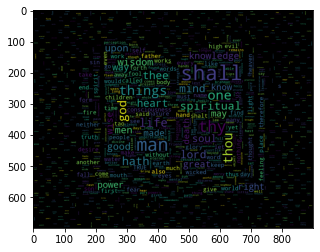

In [24]:
# word cloud visualizations 
plt.imshow(wordcloud_20)
plt.show()

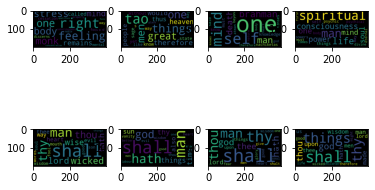

In [27]:
figure, axes = plt.subplots(nrows=2, ncols=4)
axes[0,0].imshow(word_cloud_each[0]); axes[0,1].imshow(word_cloud_each[1]); axes[0,2].imshow(word_cloud_each[2])
axes[0,3].imshow(word_cloud_each[3]); axes[1,0].imshow(word_cloud_each[4]); axes[1,1].imshow(word_cloud_each[5])
axes[1,2].imshow(word_cloud_each[6]); axes[1,3].imshow(word_cloud_each[7])

plt.show()


<AxesSubplot:ylabel='book'>

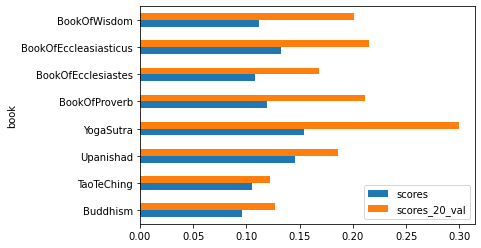

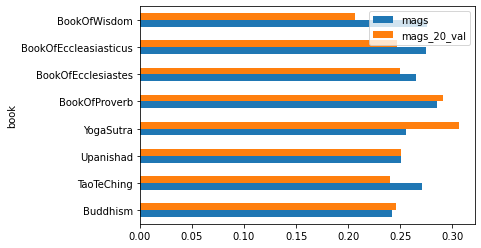

In [38]:
book_names = books
scores_val = list(book_scores_dict.values())
scores_20_val = list(scores_20.values())
mags_val = list(book_magnitude_dict.values())
mags_20_val = list(magnitude_20.values())

scores_table = pd.DataFrame().assign(book = book_names, scores = scores_val)
mags_table = pd.DataFrame().assign(book = book_names, mags = mags_val)
scores_20_table = pd.DataFrame().assign(book = book_names, scores_20_val = scores_20_val)
mags_20_table = pd.DataFrame().assign(book = book_names, mags_20_val = mags_20_val)

scores_v_20 = scores_table.merge(scores_20_table, left_on = 'book', right_on = 'book').set_index('book')
mags_v_20 = mags_table.merge(mags_20_table, left_on = 'book', right_on = 'book').set_index('book')

scores_v_20.plot.barh()
mags_v_20.plot.barh()

plt.show